Загружаем библитеки которые могу понадобиться

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from statsmodels.stats import weightstats
from scipy.stats import norm
from scipy.stats import t

Смотрим на Датасет

In [172]:
stud_math = pd.read_csv('stud_math.csv')
display(stud_math.sample(7))
stud_math.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
217,GP,M,18,U,LE3,T,3.0,3.0,services,health,...,-6.0,yes,yes,no,NaN,2.0,4.0,4.0,13.0,40.0
301,GP,M,17,U,LE3,T,4.0,4.0,other,teacher,...,-3.0,yes,yes,no,4.0,1.0,1.0,5.0,0.0,50.0
62,GP,F,16,U,LE3,T,1.0,2.0,other,services,...,-6.0,yes,yes,no,4.0,4.0,3.0,1.0,4.0,45.0
269,GP,F,18,R,GT3,T,2.0,1.0,other,other,...,-6.0,no,yes,yes,4.0,3.0,5.0,3.0,0.0,0.0
46,GP,F,16,U,LE3,A,3.0,NaN,other,services,...,-6.0,yes,yes,no,2.0,3.0,5.0,3.0,12.0,55.0
186,GP,M,16,U,GT3,NaN,1.0,2.0,services,services,...,-3.0,yes,yes,yes,3.0,3.0,3.0,3.0,2.0,55.0
308,GP,M,19,R,GT3,T,3.0,3.0,other,services,...,-6.0,yes,NaN,NaN,4.0,5.0,3.0,5.0,0.0,60.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [173]:
stud_math.columns #вытаскиваю список колонок, что бы скорректировать названия

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

In [175]:
stud_math.columns = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime_granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'] #корректирую названия колонок

In [176]:
stud_math.studytime_granular.value_counts() #проверка работы корректировки

-6.0     194
-3.0     103
-9.0      64
-12.0     27
Name: studytime_granular, dtype: int64

Что за колонка "studytime_granular"? С чём она связана?

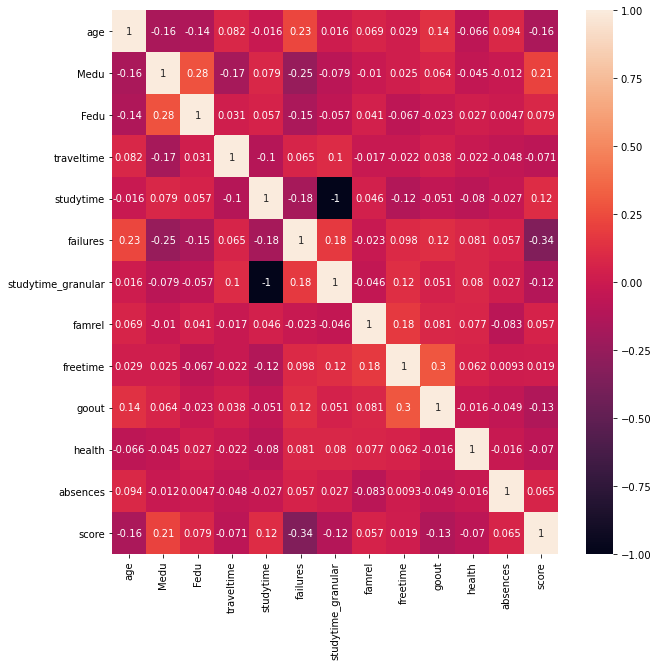

In [177]:
sns.heatmap(stud_math.corr(), annot = True)
fig = plt.gcf()
fig.set_size_inches(10, 10)

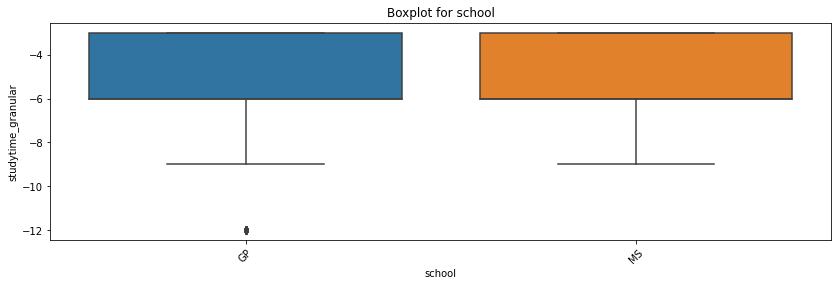

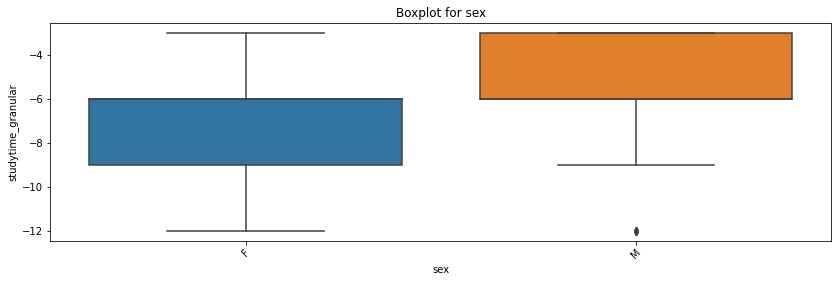

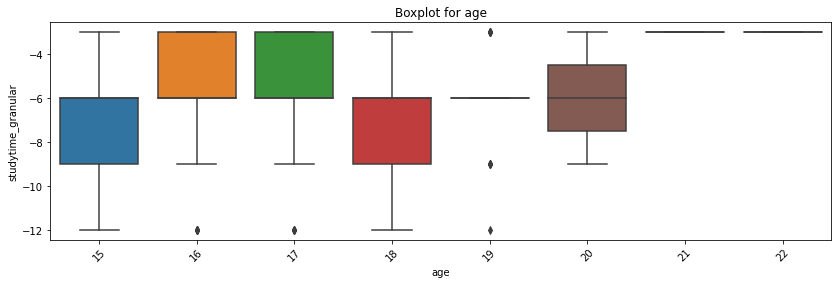

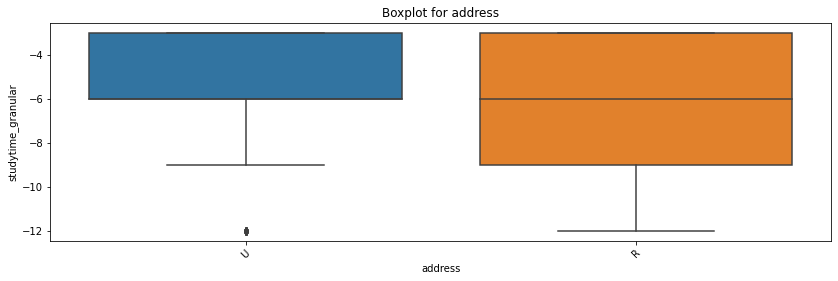

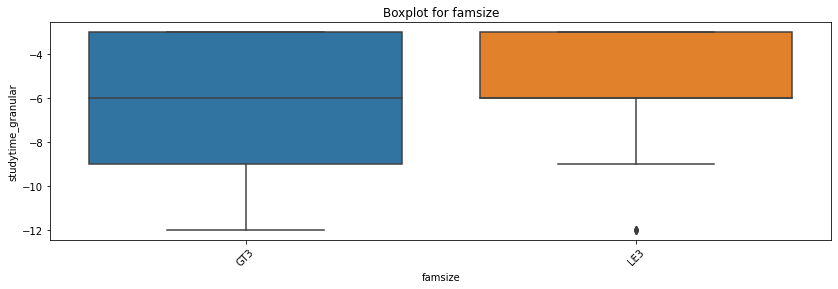

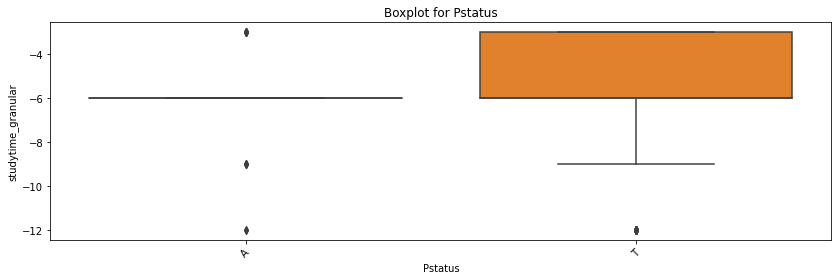

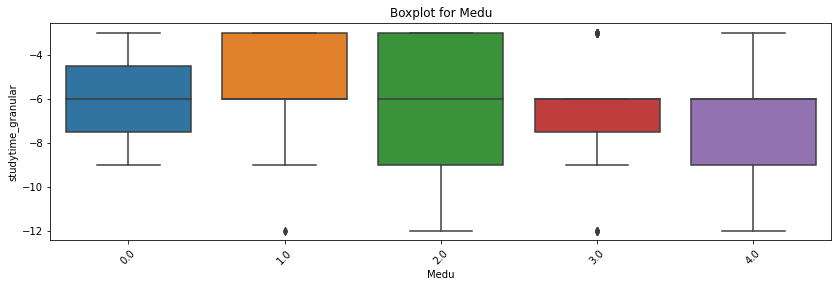

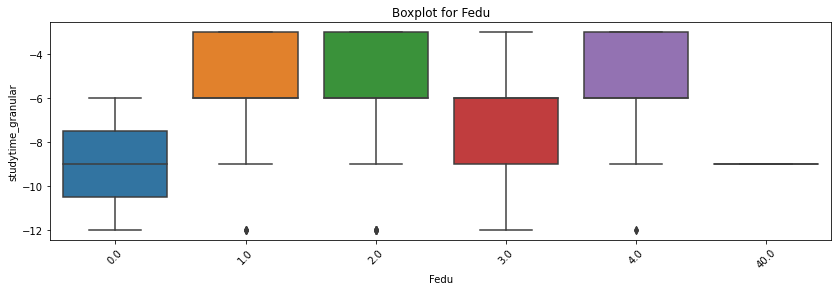

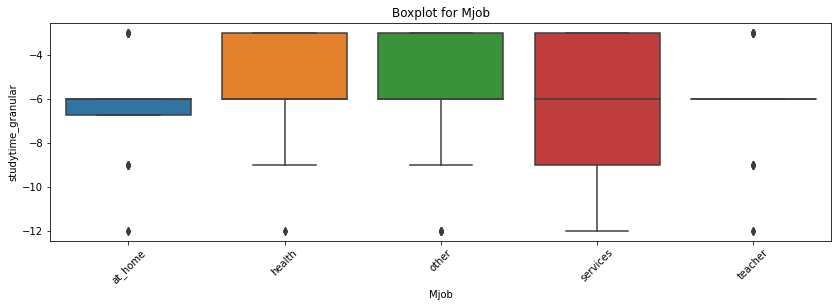

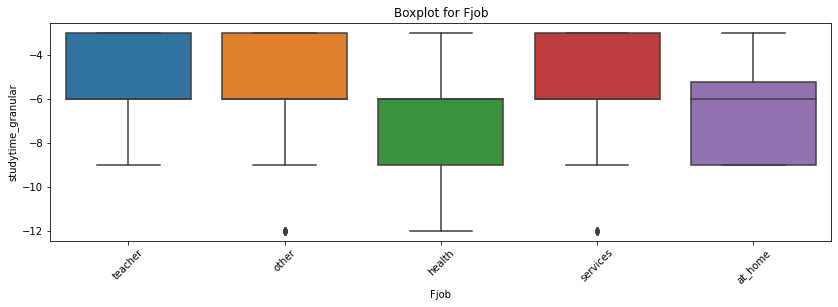

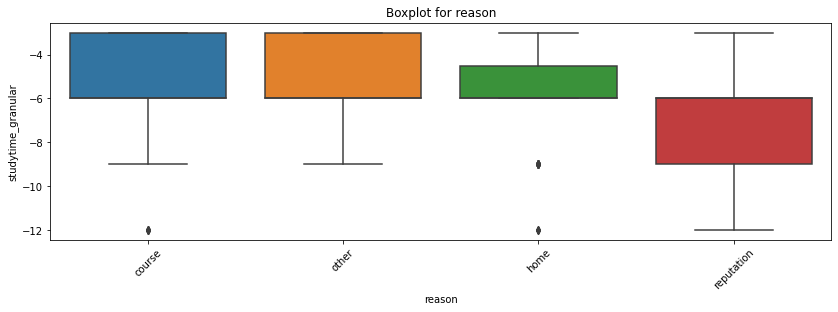

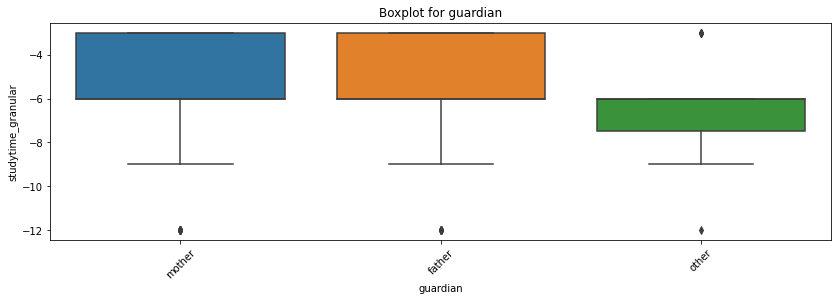

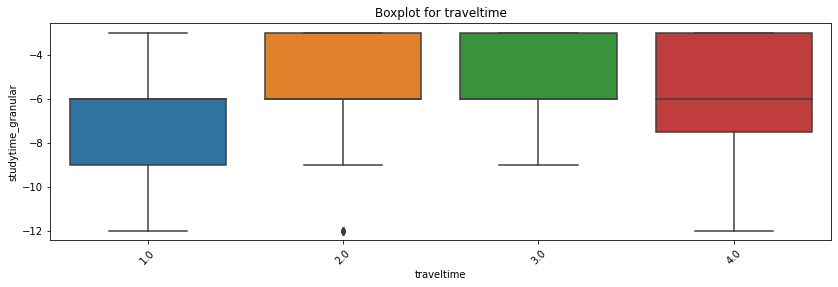

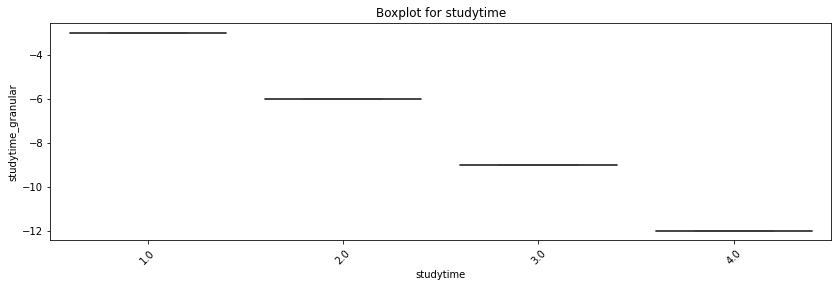

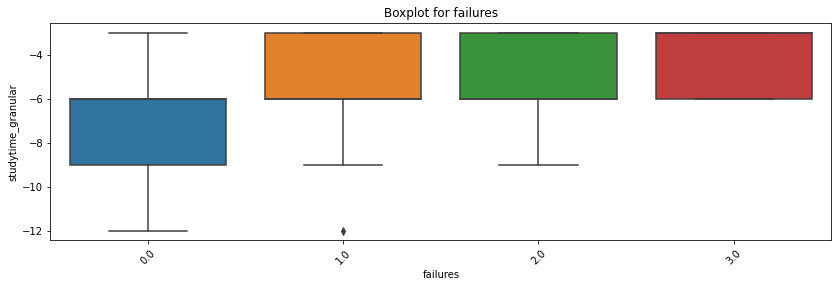

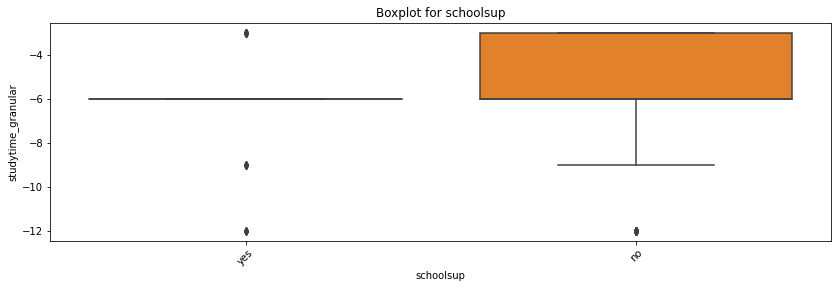

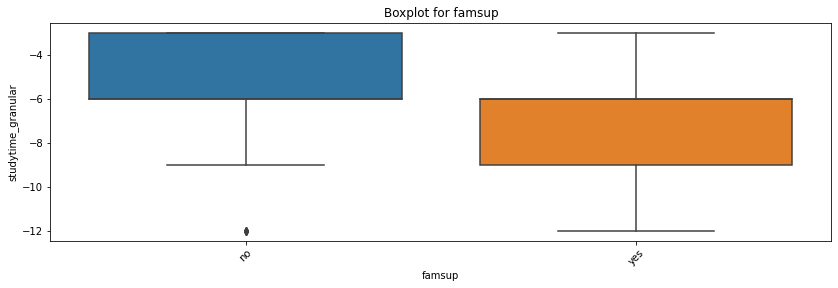

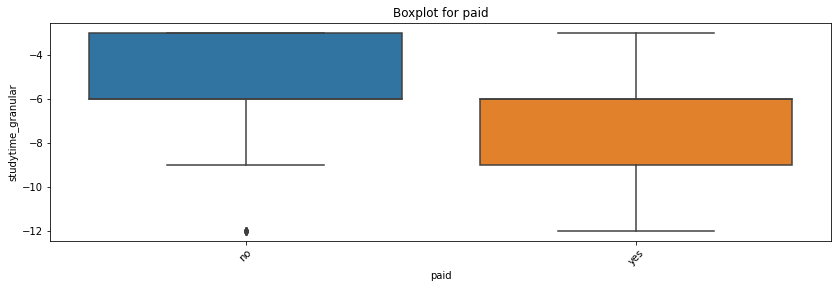

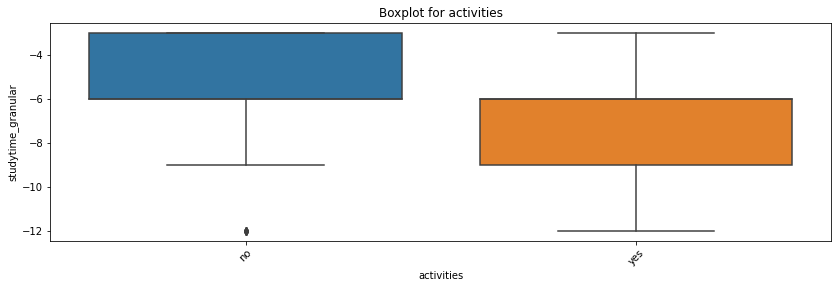

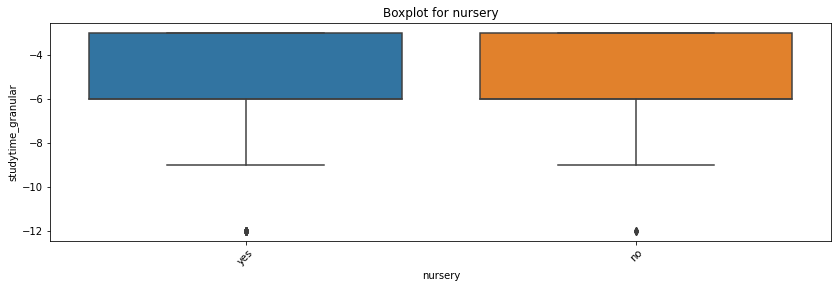

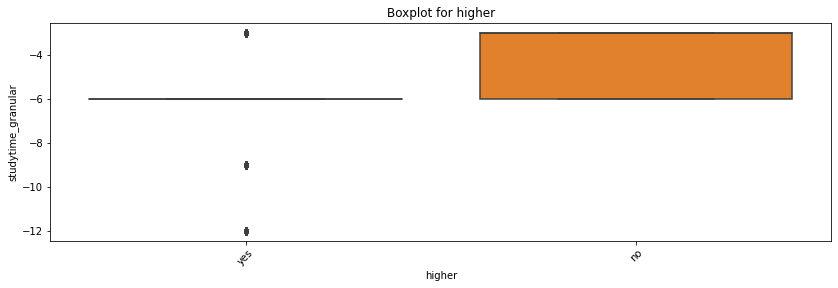

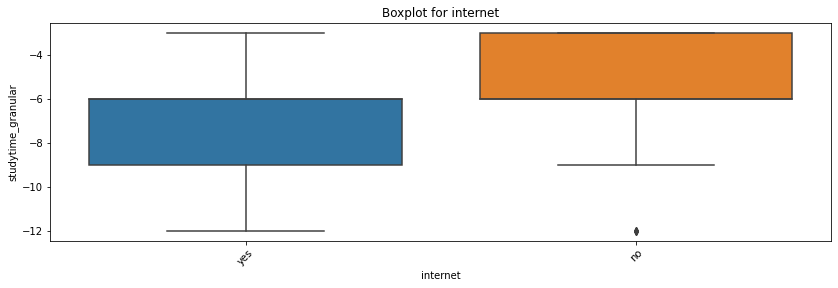

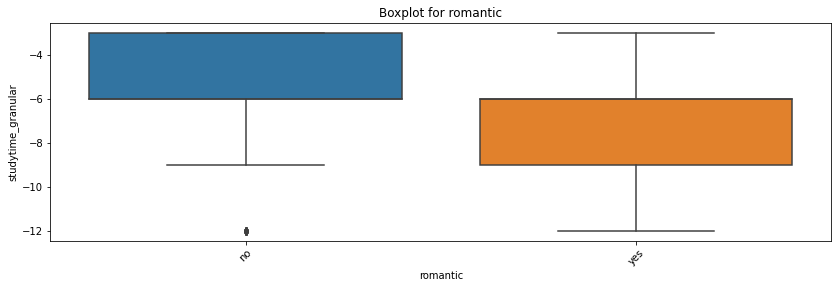

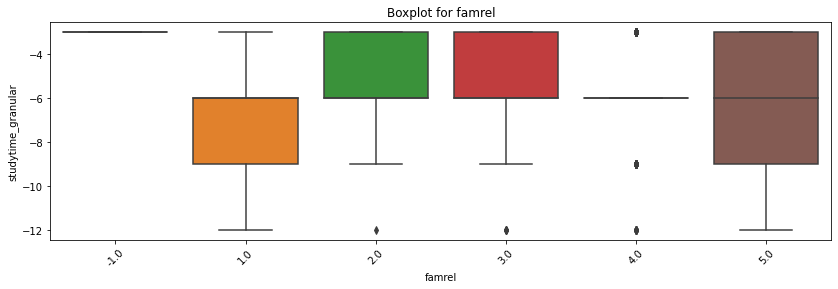

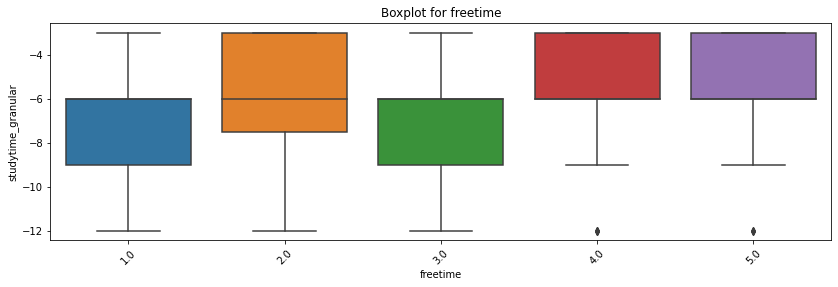

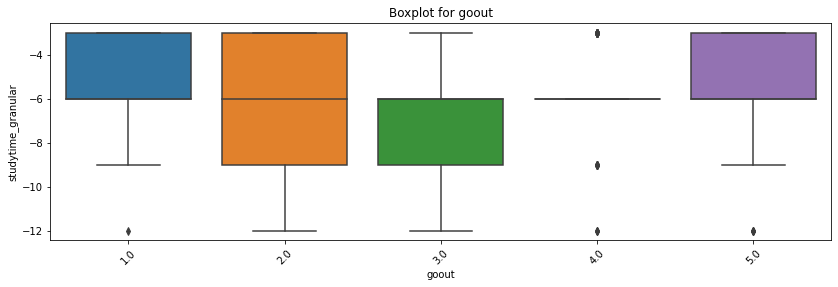

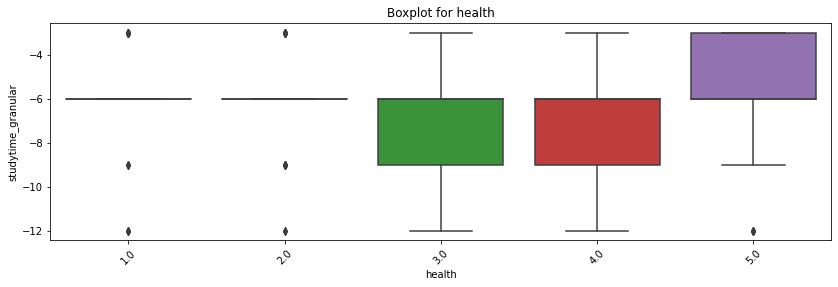

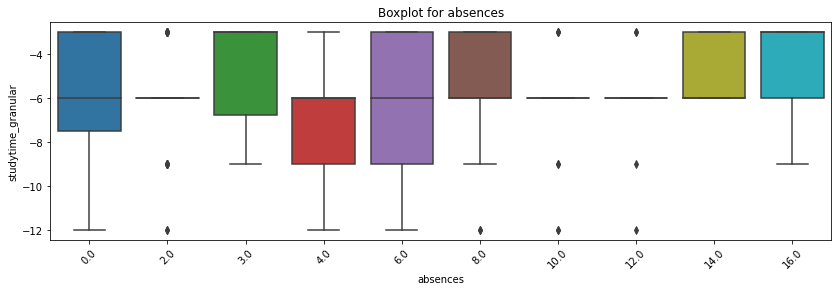

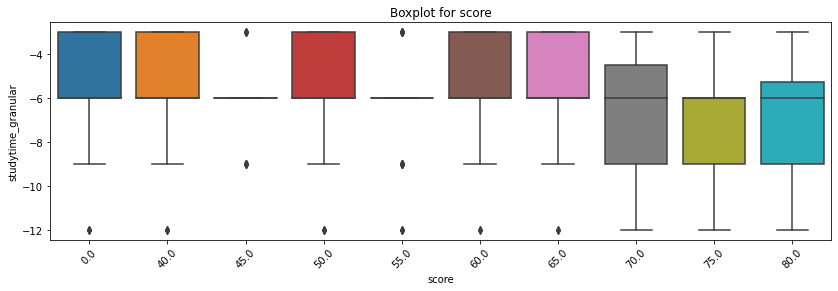

In [178]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='studytime_granular', 
                data=stud_math.loc[stud_math.loc[:, column].isin(stud_math.loc[:, column].
                                                                     value_counts().index[:10])], ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
for col in ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
        'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score']:
    get_boxplot(col)

In [179]:
del stud_math['studytime_granular'] # т.к. стобцец studytime_granular нам не известен, что за параметр и он имеет прямую 
                                    # отрицательную корреляцию с данными о времени учёбы дома, считаю, что можно его удалить

In [180]:
# создаём функцию для изменения некорректных значений в числовых столбцах
def columne_data_fix(columne_name, columne_data): 
    for i in stud_math.loc[ : , columne_name]:
        if i % 10 == 0 and i / 10 in columne_data: # если данные заданы не корректно в рамках ошибки заполнения запятой
            stud_math.loc[stud_math[columne_name] == i, columne_name] = i / 10
        elif i > max(columne_data): # заменяем некорректное знначение выше возможного на максимальное
            stud_math.loc[stud_math[columne_name] == i, columne_name] = max(columne_data)
        elif i < min(columne_data): # заменяем некорректное знначение выше возможного на минимальное
            stud_math.loc[stud_math[columne_name] == i, columne_name] = min(columne_data)
    
    # заполняем пустые значения на возможные в рамказ вероятностного значения
    nan_data = stud_math[columne_name].isna() # создайм переменную с нулевыми значениями 
    # считаю вероятнасть того или иного значения
    p = stud_math[columne_name].value_counts() / len(stud_math[columne_name].dropna())
    # заполняем пропуски с вероятностью `p`
    stud_math.loc[nan_data, columne_name] = \
        np.random.choice(p.index.to_list(), 
                         size=nan_data.sum(), 
                         p=p.to_list())
            

Fedu_data = (0, 1, 2, 3, 4)
columne_data_fix('Fedu', Fedu_data)

In [181]:
stud_math.Fedu.value_counts() # проверка работы функции

2.0    111
3.0    102
4.0     97
1.0     82
0.0      3
Name: Fedu, dtype: int64

In [182]:
stud_math.describe() # проверка работы функции

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
count,395.000000,392.000000,395.000000,367.000000,388.000000,373.000000,368.000000,384.000000,387.000000,380.000000,383.000000,389.000000
mean,16.696203,2.750000,2.526582,1.438692,2.038660,0.337802,3.937500,3.231771,3.105943,3.531579,7.279373,52.262211
std,1.276043,1.098127,1.097379,0.694181,0.842078,0.743135,0.927277,0.993940,1.115896,1.396019,23.465197,22.919022
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,17.000000,3.000000,3.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


In [183]:
stud_math.describe() # смотрю на числовые столбцы

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
count,395.000000,392.000000,395.000000,367.000000,388.000000,373.000000,368.000000,384.000000,387.000000,380.000000,383.000000,389.000000
mean,16.696203,2.750000,2.526582,1.438692,2.038660,0.337802,3.937500,3.231771,3.105943,3.531579,7.279373,52.262211
std,1.276043,1.098127,1.097379,0.694181,0.842078,0.743135,0.927277,0.993940,1.115896,1.396019,23.465197,22.919022
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,17.000000,3.000000,3.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


In [184]:
# по всем однозначым числовым столбцам корректируем данные
Medu_data = (0, 1, 2, 3, 4)
columne_data_fix('Medu', Medu_data)

traveltime_data = (1, 2, 3, 4)
columne_data_fix('traveltime', traveltime_data)

studytime_data = (1, 2, 3, 4)
columne_data_fix('studytime', studytime_data)

failures_data = (0, 1, 2, 3)
columne_data_fix('failures', failures_data)

famrel_data = (1, 2, 3, 4, 5)
columne_data_fix('famrel', famrel_data)

freetime_data = (1, 2, 3, 4, 5)
columne_data_fix('freetime', freetime_data)

goout_data = (1, 2, 3, 4, 5)
columne_data_fix('goout', goout_data)

health_data = (1, 2, 3, 4, 5)
columne_data_fix('health', health_data)

In [186]:
stud_math.describe() # проверяем итог работы функции по корректировке и заполнению данных

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,383.000000,389.000000
mean,16.696203,2.754430,2.526582,1.440506,2.030380,0.349367,3.941772,3.230380,3.101266,3.534177,7.279373,52.262211
std,1.276043,1.098199,1.097379,0.707738,0.839439,0.760355,0.909148,0.997504,1.117409,1.385465,23.465197,22.919022
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,17.000000,3.000000,3.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


В столбце score - 100 максимальное значение, 0 - минимальное. Поэтому считать что в данном столбце есть выбросы считаю некорректно.
Смотрим на столбец absences

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [0, 20.0].


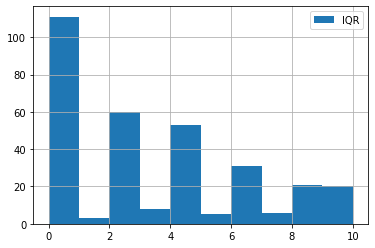

In [198]:
IQR = stud_math.absences.quantile(0.75) - stud_math.absences.quantile(0.25)
perc25 = stud_math.absences.quantile(0.25)
perc75 = stud_math.absences.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=0, l=perc75 + 1.5*IQR))
 
stud_math.absences.loc[stud_math.absences.between(0, perc75 + 1.5*IQR)].hist(bins = 10, range = (0, 10), label = 'IQR')
 
plt.legend();

In [200]:
# считаем количество значений выше границы выброса
j=0
for i in stud_math.absences:
    if i > 20:
        j += 1
print(j)

17


Количество выбросов 17 или 4,3% от всех данных. На итоговое количество полученных балов, количество пропущенных уроков влияет слабо(из цифровых данных 3 место с конца). Поэтому выбросы приравниваем к границе выброса. Но при итоговой оценке учитываем, что количество пропущенных занятий это граница, и при необхомости пишем "Пропущено более 20 занятий".  

In [203]:
for i in stud_math.absences:
    if i > 20: # заменяем знначение выше границы выброса на границу выброса
        stud_math.loc[stud_math['absences'] == i, 'absences'] = 20
    
    # заполняем пустые значения на возможные в рамказ вероятностного значения
    nan_data = stud_math['absences'].isna() # создайм переменную с нулевыми значениями 
    # считаю вероятнасть того или иного значения
    p = stud_math['absences'].value_counts() / len(stud_math['absences'].dropna())
    # заполняем пропуски с вероятностью `p`
    stud_math.loc[nan_data, 'absences'] = \
        np.random.choice(p.index.to_list(), 
                         size=nan_data.sum(), 
                         p=p.to_list())
stud_math.absences.describe() # проверяем полученные данные

count    395.000000
mean       5.291139
std        5.802047
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max       20.000000
Name: absences, dtype: float64

In [207]:
# заполняем пустые значения на возможные в рамказ вероятностного значения
nan_data = stud_math['score'].isna() # создайм переменную с нулевыми значениями 
# считаю вероятнасть того или иного значения
p = stud_math['score'].value_counts() / len(stud_math['score'].dropna())
# заполняем пропуски с вероятностью `p`
stud_math.loc[nan_data, 'score'] = \
    np.random.choice(p.index.to_list(), 
                      size=nan_data.sum(), 
                      p=p.to_list())
stud_math.score.describe() # проверяем полученные данные

count    395.000000
mean      52.455696
std       22.811186
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

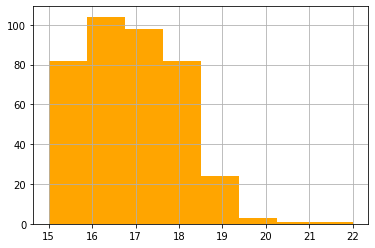

In [239]:
stud_math.age.hist(color = 'orange', bins = len(stud_math.age.unique()))

Основная масса учеников в возрасте от 15 до 18 лет

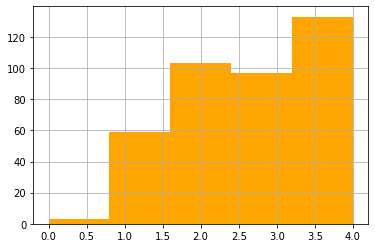

In [238]:
stud_math.Medu.hist(color = 'orange', bins = len(stud_math.Medu.unique()))

В основной массе образвание матерей учеников 5-9 классов, 11 классов или ср-специальное и высшее образование

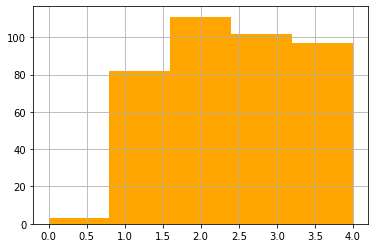

In [240]:
stud_math.Fedu.hist(color = 'orange', bins = len(stud_math.Fedu.unique()))

Образование отцов ниже. чес образование матерей.

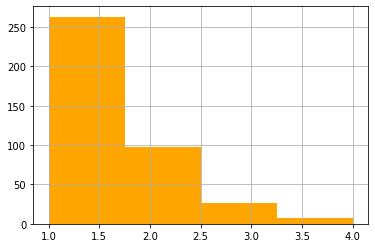

In [243]:
stud_math.traveltime.hist(color = 'orange', bins = len(stud_math.traveltime.unique()))

Более 50% учеников живут менее чем в 15 мин пути от школы.

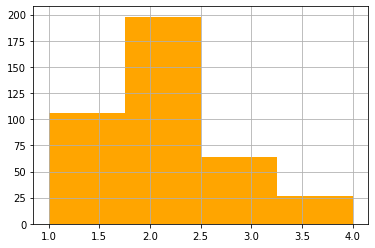

In [249]:
stud_math.studytime.hist(color = 'orange', bins = len(stud_math.studytime.unique()))

Врямя на учёбу более чем у 75% учеников до 2,5 часов.

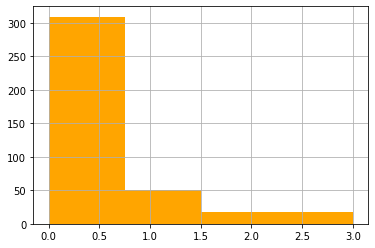

In [244]:
stud_math.failures.hist(color = 'orange', bins = len(stud_math.failures.unique()))

Более чем у 75% учеников нет внеучебных неудач.

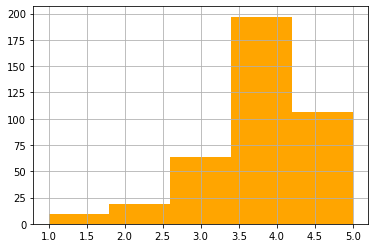

In [245]:
stud_math.famrel.hist(color = 'orange', bins = len(stud_math.famrel.unique()))

Более чем у 75% учеников отношения в семье хорошие или очень хорошие.

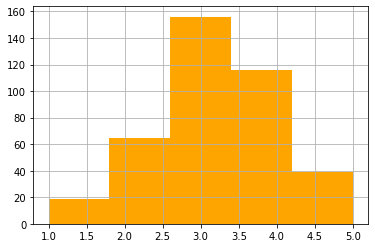

In [247]:
stud_math.freetime.hist(color = 'orange', bins = len(stud_math.freetime.unique()))

Распределение свободного времени нормальное.

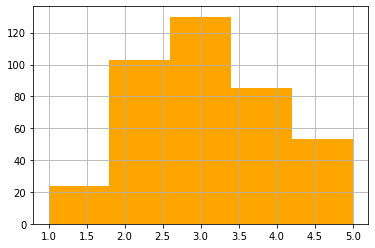

In [248]:
stud_math.goout.hist(color = 'orange', bins = len(stud_math.goout.unique()))

Время проведённое с друзьями сопоставимо со свободным временем.

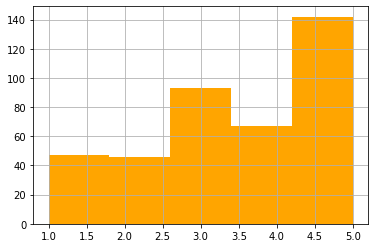

In [251]:
stud_math.health.hist(color = 'orange', bins = len(stud_math.health.unique()))

Очень хорошее здоровье всего у 35% учеников.

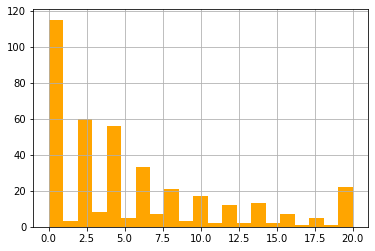

In [252]:
stud_math.absences.hist(color = 'orange', bins = len(stud_math.absences.unique()))

Всего порядка 30% учеников не пропускали занятие вообще.

50.0     54
55.0     47
0.0      37
75.0     34
65.0     33
60.0     32
40.0     31
70.0     28
45.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64

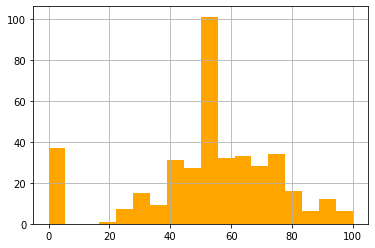

In [255]:
stud_math.score.hist(color = 'orange', bins = len(stud_math.score.unique()))
stud_math.score.value_counts()

Порядка 9% учеников, не сдавали вообще тест по математике. Общее распределение оценок нормально, с сильно выраженным наибольшем количеством учеников получивших 50-55 баллов.

In [205]:
stud_math.describe(include = ['object']) # посмотрим на нормативные переменные

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
count,395,395,378,368,350,376,359,378,364,386,356,355,381,379,375,361,364
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,349,208,295,261,314,133,197,137,250,335,219,200,195,300,356,305,240


Как видим из описания количество уникальных значений совпадает с количество возможных ответов. Значит вероятность некорректных значений низкая. 
Напишем функцию, которая будет заполнят незаполненные столбцы исходя из вероятностного значения и пропусттим через неё все данные, что бы все столбцы были заполнены для увеличения количества данных и как следствие более точных итоговых ввыводов.

In [210]:
def columne_object_fix(columne_name):
    # заполняем пустые значения на возможные в рамказ вероятностного значения
    nan_data = stud_math[columne_name].isna() # создайм переменную с нулевыми значениями 
    # считаю вероятнасть того или иного значения
    p = stud_math[columne_name].value_counts() / len(stud_math[columne_name].dropna())
    # заполняем пропуски с вероятностью `p`
    stud_math.loc[nan_data, columne_name] = \
        np.random.choice(p.index.to_list(), 
                         size=nan_data.sum(), 
                         p=p.to_list())
# прогоняем все стобцы через функцию
for col in ['school', 'sex', 'address', 'famsize', 'Pstatus',
       'Mjob', 'Fjob', 'reason', 'guardian','schoolsup', 'famsup', 'paid', 'activities', 'nursery',
        'higher', 'internet', 'romantic']:
    columne_object_fix(col)

In [212]:
stud_math.describe(include = ['object'])

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
count,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,349,208,311,281,354,142,216,146,273,342,246,220,201,312,374,338,259


In [214]:
# смотрим что получилось
display(stud_math.sample(7))
stud_math.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
171,GP,M,16,U,GT3,T,1.0,0.0,other,other,...,yes,yes,yes,yes,4.0,3.0,2.0,3.0,2.0,80.0
121,GP,M,15,U,GT3,T,2.0,2.0,services,services,...,yes,yes,yes,no,5.0,5.0,4.0,5.0,6.0,75.0
139,GP,F,15,U,GT3,T,4.0,4.0,teacher,teacher,...,yes,yes,yes,no,4.0,3.0,2.0,5.0,0.0,75.0
159,GP,M,16,R,GT3,T,3.0,2.0,other,services,...,yes,yes,yes,yes,4.0,5.0,5.0,5.0,4.0,60.0
260,GP,F,18,U,GT3,T,4.0,3.0,other,other,...,yes,yes,yes,yes,3.0,1.0,2.0,2.0,20.0,90.0
22,GP,M,16,U,LE3,T,4.0,2.0,teacher,health,...,yes,yes,yes,no,4.0,5.0,1.0,5.0,2.0,80.0
23,GP,M,16,U,LE3,T,2.0,2.0,other,other,...,yes,yes,yes,no,5.0,4.0,4.0,5.0,0.0,60.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      395 non-null    object 
 1   sex         395 non-null    object 
 2   age         395 non-null    int64  
 3   address     395 non-null    object 
 4   famsize     395 non-null    object 
 5   Pstatus     395 non-null    object 
 6   Medu        395 non-null    float64
 7   Fedu        395 non-null    float64
 8   Mjob        395 non-null    object 
 9   Fjob        395 non-null    object 
 10  reason      395 non-null    object 
 11  guardian    395 non-null    object 
 12  traveltime  395 non-null    float64
 13  studytime   395 non-null    float64
 14  failures    395 non-null    float64
 15  schoolsup   395 non-null    object 
 16  famsup      395 non-null    object 
 17  paid        395 non-null    object 
 18  activities  395 non-null    object 
 19  nursery     395 non-null    o

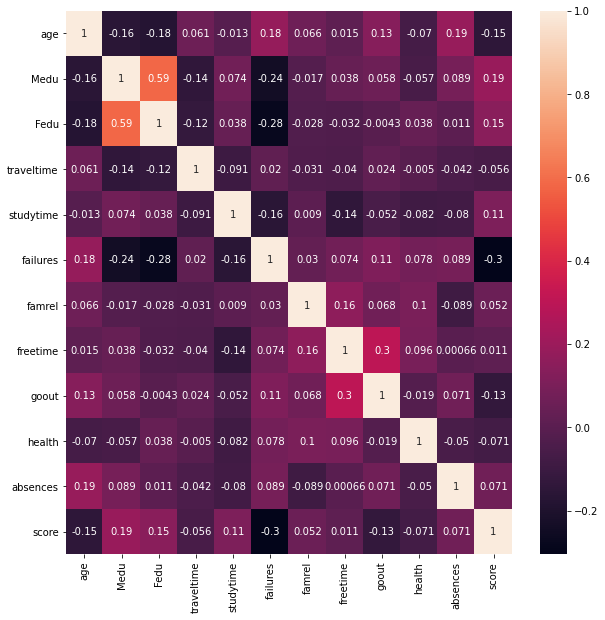

In [216]:
sns.heatmap(stud_math.corr(), annot = True) #строим корреляционную тепловую карту цифровых значений
fig = plt.gcf()
fig.set_size_inches(10, 10)

Исходя из данных можно исключить freetime, т.к. цифра корреляции в рамках 1%; health, т.к. helth и absences, показывают одинаковое значение корреляции, но в разном направлении, что можно интерпритировать, что чем более здоровый ученик, тем меньше он пропускл и тем выше получил итоговый бал. 

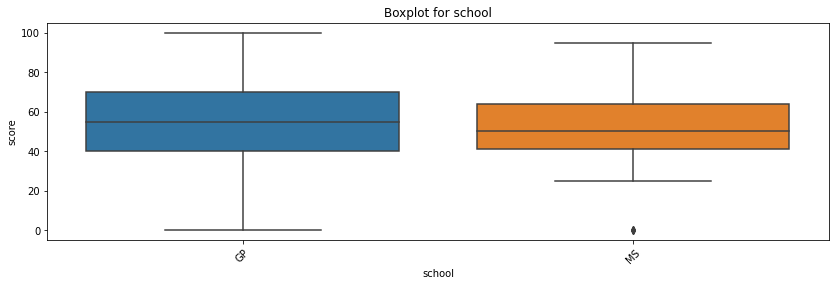

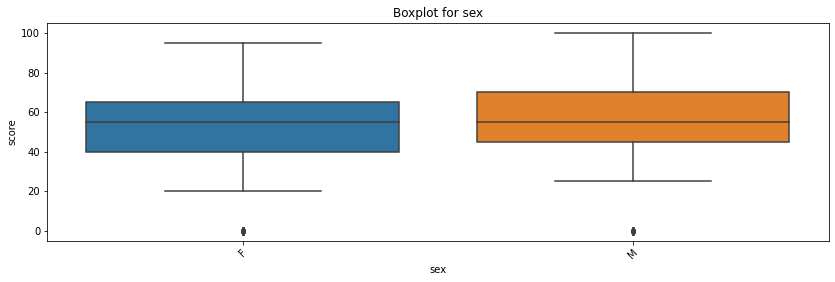

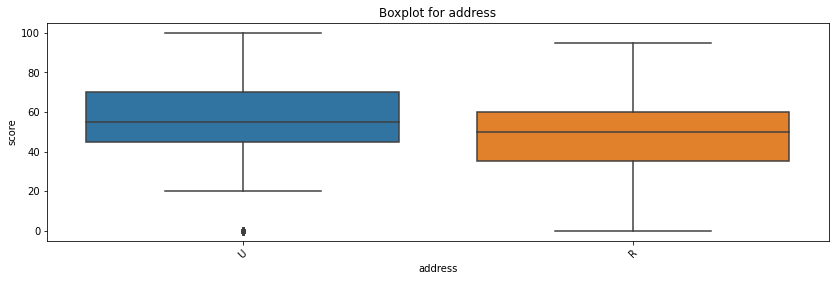

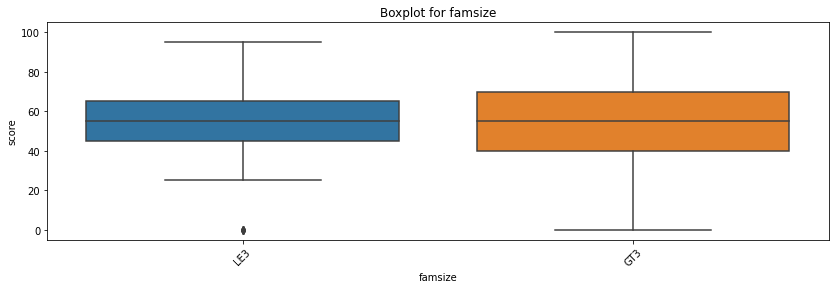

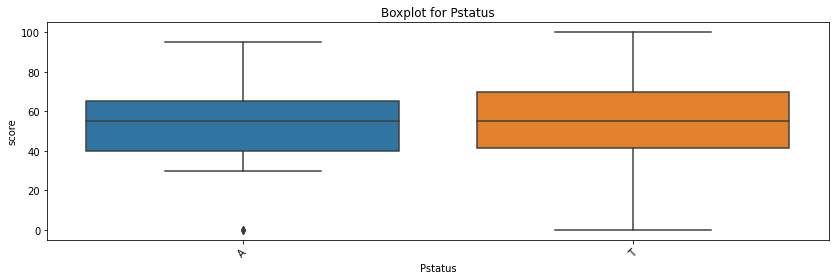

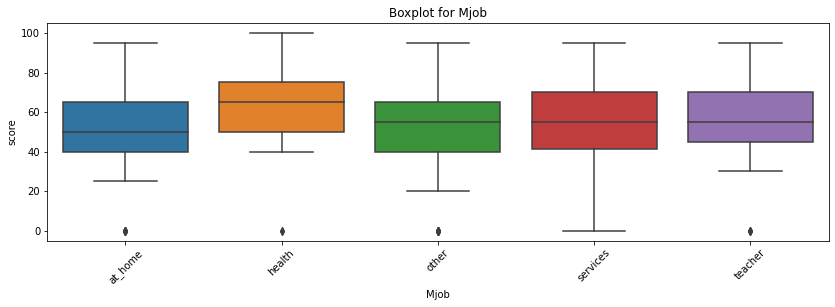

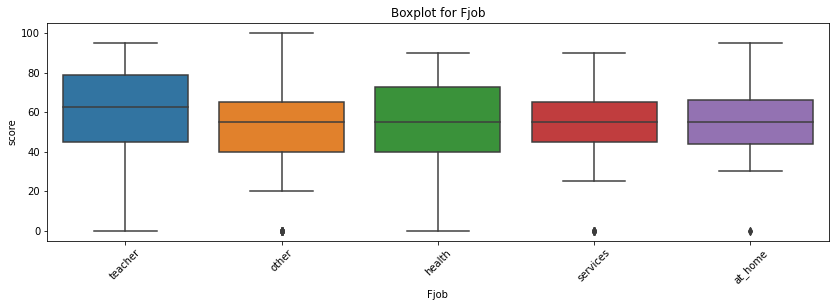

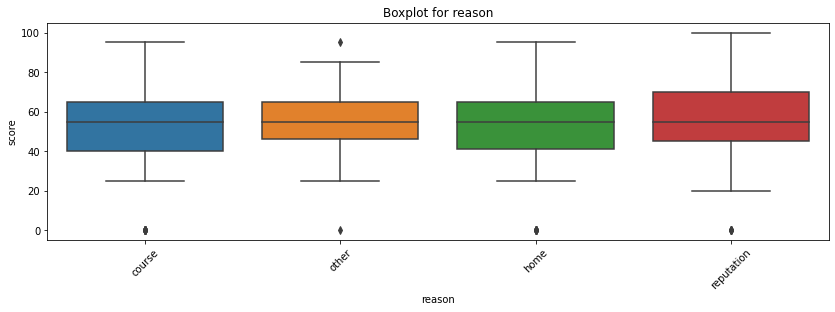

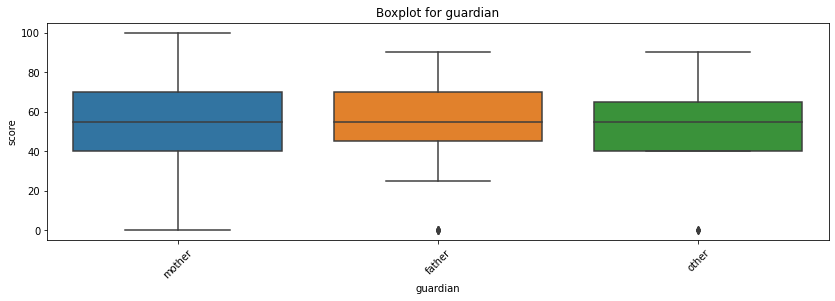

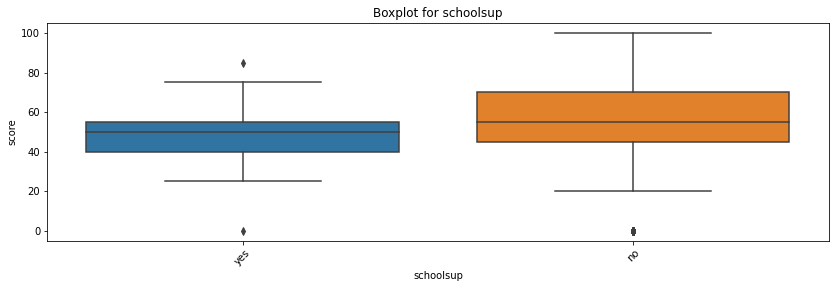

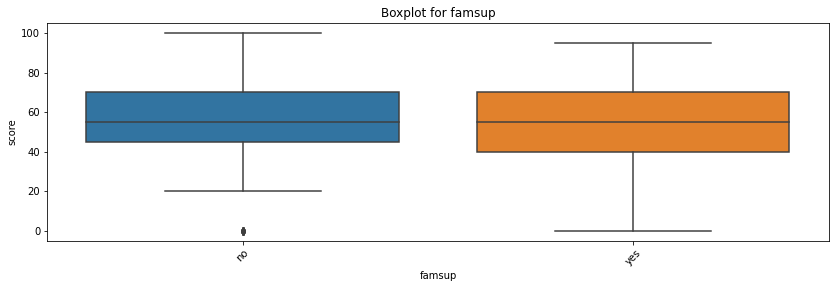

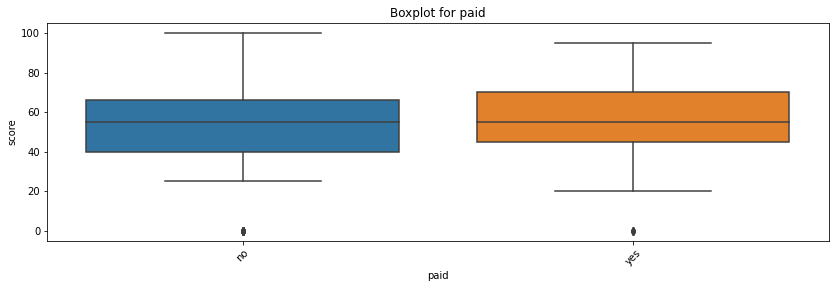

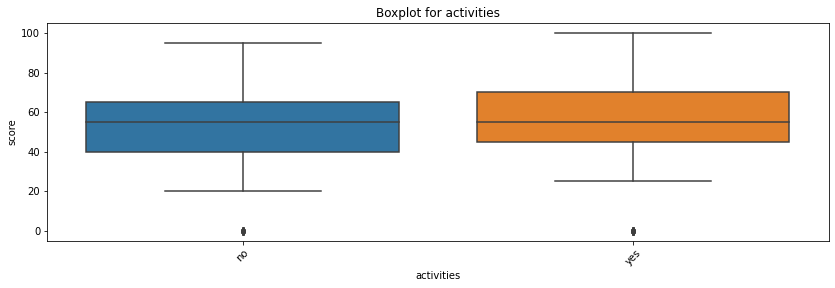

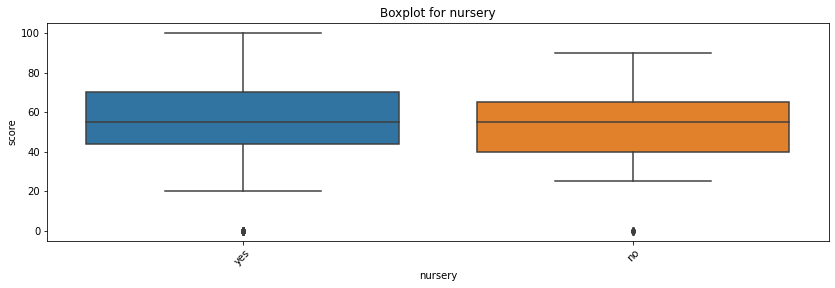

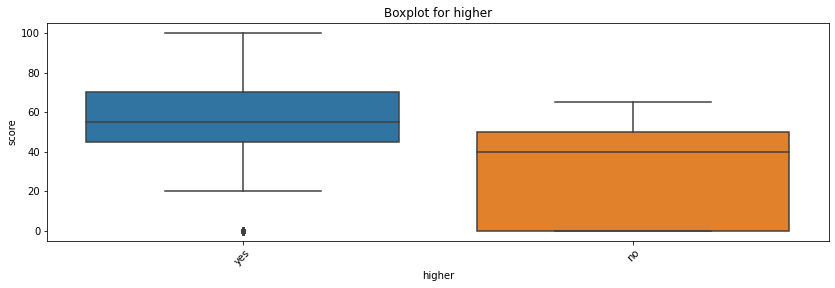

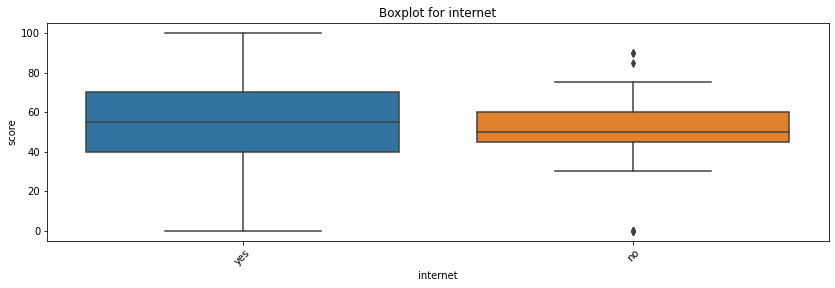

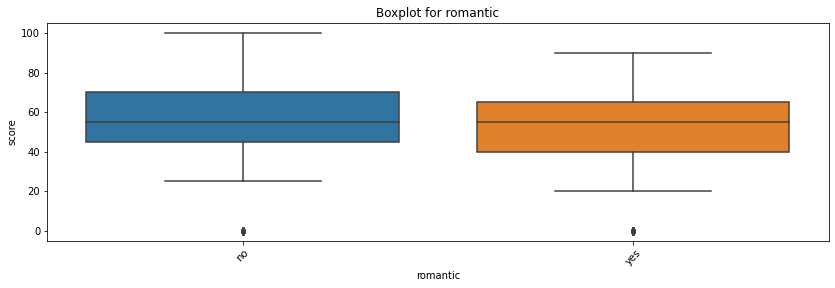

In [217]:
def get_boxplot(column): # строим графики для понимания влияния номинальных данных на итоговую оценку теста по математике
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=stud_math.loc[stud_math.loc[:, column].isin(stud_math.loc[:, column].
                                                                     value_counts().index[:10])], ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    
for col in ['school', 'sex', 'address', 'famsize', 'Pstatus',
       'Mjob', 'Fjob', 'reason', 'guardian','schoolsup', 'famsup', 'paid', 'activities', 'nursery',
        'higher', 'internet', 'romantic']:
    get_boxplot(col)

Визуально видно, что итоговая оценка зависит от данных в столбцах adress(оценки в городе выше), Mjob(у детей, чья мать работает в здравоохранении оценки выше), Fjob(у отцов уителей дети получают более высокие оценки), schoolsup(если дополнительная образовательная поддержка есть, оценки выше), higher(если хочет получить высшее образование, оценки выше).
Проверим наши выводы с помощью теста Стьюдента. Проверим нулевую гипотезуб что распределения оценок по различным параметрам неразличимы.

In [224]:
def get_stat_dif(column):
    cols = stud_math.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud_math.loc[stud_math.loc[:, column] == comb[0], 'score'], 
                        stud_math.loc[stud_math.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [225]:
for col in ['school', 'sex', 'address', 'famsize', 'Pstatus',
       'Mjob', 'Fjob', 'reason', 'guardian','schoolsup', 'famsup', 'paid', 'activities', 'nursery',
        'higher', 'internet', 'romantic']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


В итоге у нас остаются для дальнейшей обработки столбцы: address, Mjob, higher, romantic, age, Medu, Fedu, traveltime, studytime, failures, famrel, goout, health, score.

In [ ]:
stud_math_model = stud_math.loc[:, ['address', 'Mjob', 'higher', 'romantic', 'age', 'Medu', 'Fedu', 
                                    'traveltime', 'studytime', 'failures', 'famrel', 'goout', 'health', 'score'] ]

In [231]:
stud_math_model.sample(7)

,address,Mjob,higher,romantic,age,Medu,Fedu,traveltime,studytime,failures,famrel,goout,health,score
193,R,services,yes,no,16,2.0,3.0,1.0,1.0,0.0,4.0,2.0,5.0,50.0
261,U,teacher,yes,no,18,4.0,3.0,2.0,2.0,0.0,4.0,2.0,3.0,40.0
206,U,services,yes,no,16,3.0,1.0,1.0,2.0,3.0,2.0,3.0,4.0,35.0
391,U,services,yes,no,17,3.0,1.0,2.0,1.0,0.0,2.0,5.0,2.0,80.0
313,U,services,yes,yes,19,3.0,2.0,2.0,2.0,0.0,4.0,2.0,1.0,55.0
122,U,other,yes,yes,16,2.0,4.0,2.0,2.0,0.0,4.0,2.0,5.0,65.0
166,U,other,no,no,16,2.0,2.0,1.0,2.0,0.0,4.0,5.0,4.0,50.0
